In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Embedding, Dense, Conv1D, Flatten, Concatenate, Dropout
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

## Load Data

In [2]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

In [3]:
print(f"Training dataset size: {X_train.shape, y_train.shape}")
print(f"Test dataset size: {X_test.shape, y_test.shape}")

Training dataset size: ((1482243, 97), (1482243,))
Test dataset size: ((635247, 97), (635247,))


In [4]:
X_train = X_train.astype({col: 'float64' for col in X_train.select_dtypes(include=['boolean']).columns})
X_test = X_test.astype({col: 'float64' for col in X_test.select_dtypes(include=['boolean']).columns})

In [5]:
# mapping for y from data_preprocess notebook
class_mapping = {
    0: 'Backdoor',
    1: 'DDoS_HTTP',
    2: 'DDoS_ICMP',
    3: 'DDoS_TCP',
    4: 'Normal', 
    5: 'OS_Fingerprinting',
    6: 'Password',
    7: 'Port_Scanning',
    8: 'Ransomware',
    9: 'SQL_injection',
    10: 'Uploading',
    11: 'Vulnerability_scanner',
    12: 'XSS'
}

In [6]:
def hist(y):
    plt.figure(figsize=(10, 6))
    plt.hist(y, bins=np.arange(-0.5, len(class_mapping)))

    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    plt.xticks(ticks=np.arange(len(class_mapping)), labels=list(class_mapping.values()), rotation=45)
    plt.xlim(-0.5, len(class_mapping) - 0.5)  

    plt.tight_layout()


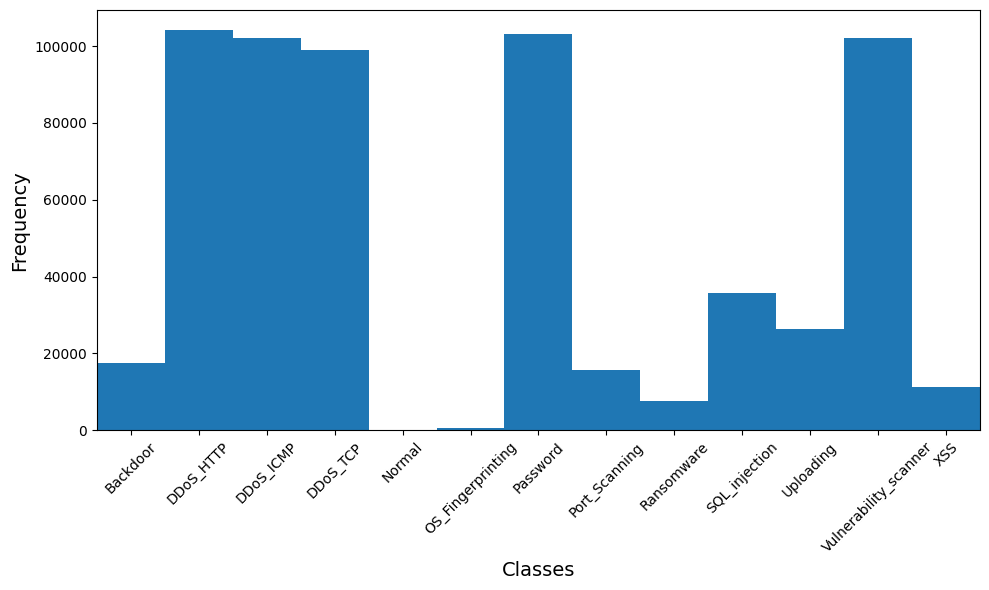

In [7]:
# for train set
# get attack classes only
y_train_df = pd.DataFrame(y_train, columns=['attack_label'])
df_train = pd.concat([pd.DataFrame(X_train), y_train_df], axis=1)
df_train = df_train[df_train['attack_label'] != 4]
X_train = df_train.drop('attack_label', axis=1)
y_train = df_train['attack_label']
hist(y_train)

imbalanced for 0,5,7,8,9,10,12

In [8]:
# for test set
# get attack classes only
y_test_df = pd.DataFrame(y_test, columns=['attack_label'])
df_test = pd.concat([pd.DataFrame(X_test), y_test_df], axis=1)
df_test = df_test[df_test['attack_label'] != 4]
df_test['attack_label'].nunique()
X_test = df_test.drop('attack_label', axis=1)
y_test = df_test['attack_label']

In [9]:
print(f"Training dataset size for attack classes: {X_train.shape, y_train.shape}")
print(f"Test dataset size for attack classes: {X_test.shape, y_test.shape}")

Training dataset size for attack classes: ((625403, 97), (625403,))
Test dataset size for attack classes: ((268030, 97), (268030,))


## Handle Attack Class Imbalance with SMOTE

In [10]:
# handle class imbalance for training set
smote = SMOTE(random_state=4266)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled dataset size: {X_resampled.shape, y_resampled.shape}")

Resampled dataset size: ((1250424, 97), (1250424,))


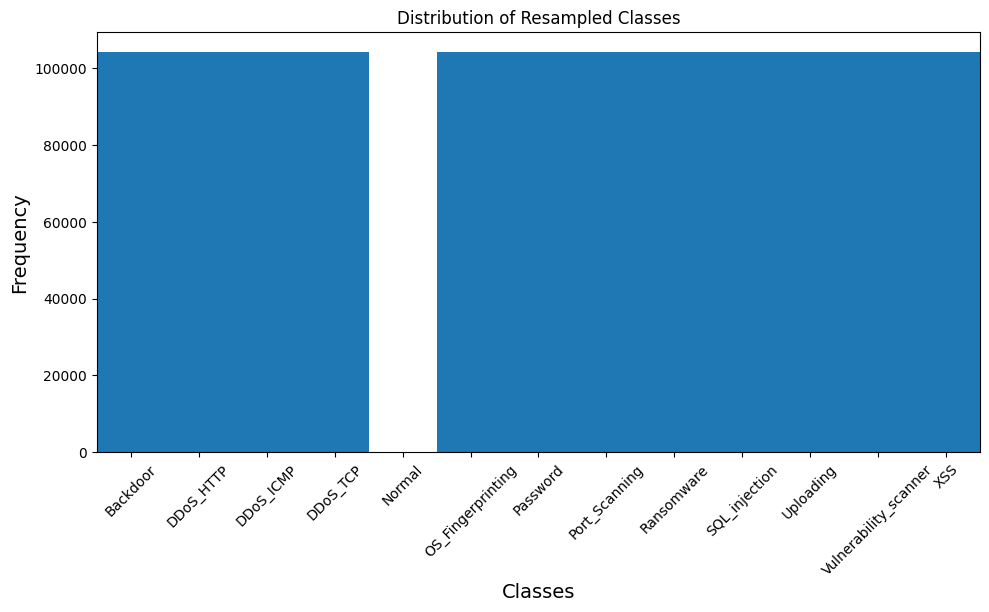

In [11]:
hist(y_resampled)
plt.title('Distribution of Resampled Classes')
plt.show()

In [12]:
# combine for aggregation
y_train_df = pd.DataFrame(y_resampled, columns=['attack_label'])
combined_df = pd.concat([X_resampled, y_train_df], axis=1)
# combine for aggregation
# y_train_df = pd.DataFrame(y_train, columns=['attack_label'])
# combined_df = pd.concat([X_train, y_train_df], axis=1)

In [13]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250424 entries, 0 to 1250423
Data columns (total 98 columns):
 #   Column                                                                                                Non-Null Count    Dtype  
---  ------                                                                                                --------------    -----  
 0   frame.time                                                                                            1250424 non-null  int64  
 1   ip.src_host                                                                                           1250424 non-null  float64
 2   ip.dst_host                                                                                           1250424 non-null  float64
 3   arp.dst.proto_ipv4                                                                                    1250424 non-null  float64
 4   arp.src.proto_ipv4                                                                  

In [14]:
X_test.drop(['frame.time', 'ip.dst_host'], axis=1, inplace=True)
X_test_cnn = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

## Group by time buckets & destination ip + aggregation

In [15]:
np.random.seed(4266)
def agg_cols(df):
    agg_dict = {}
    cols = df.columns.drop(['time_buckets', 'ip.dst_host'])
    
    for col in cols:
        if col == 'attack_label':
            agg_dict[col] = lambda x: handle_mode(x)
        else:
            agg_dict[col] = 'mean'  # Use mean for other columns
    return agg_dict

def handle_mode(x):
    modes = x.mode()
    if len(modes) == 1:
        return modes[0]  
    elif len(modes) > 1:
        return random.choice(modes)  
    else:
        return x.iloc[0]  # if mode is empty

In [16]:
def discretize_by_time_buckets(df, interval):
    # Create time buckets column based on the specified interval
    df['time_buckets'] = pd.cut(
        df['frame.time'],
        bins=range(int(df['frame.time'].min()), int(df['frame.time'].max()) + interval, interval)
    )
    
    # Drop the original 'frame.time' column
    df.drop('frame.time', axis=1, inplace=True)
    
    # Apply the aggregation function
    agg_dict = agg_cols(df)
    agg_df = df.groupby(['ip.dst_host', 'time_buckets'], observed=True).agg(agg_dict)
    
    print("Number of rows after aggregation: ", len(agg_df))
    # Separate features and labels
    X = np.array(agg_df.drop('attack_label', axis=1))
    y = np.array(agg_df['attack_label'])
    
    return X, y

## CNN with 5-fold CV + Evaluation metrics

In [17]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(13, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
def conf_matrix(y_pred_classes):
    # Calculate the confusion matrix based on actual and predicted classes
    # Only include classes that are present in y_test and y_pred_classes
    present_classes = sorted(set(y_test) | set(y_pred_classes))
    conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=present_classes)
    
    # Create a list of class names that are present
    present_class_names = [class_mapping[cls] for cls in present_classes]

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=present_class_names, yticklabels=present_class_names)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of Model Attack Predictions')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [19]:
def auc_roc_curve(y_score):
    # see sklearn documentation OvR ROC
    lb = LabelBinarizer()
    y_test_onehot = lb.fit_transform(y_test)
    
    # Adjust y_score to match the classes in `y_test` as identified by LabelBinarizer
    existing_classes = lb.classes_
    y_score_existing = y_score[:, existing_classes]  # Use only the columns for the existing classes

    # Compute macro-average AUC
    roc_auc = {"macro": roc_auc_score(y_test_onehot, y_score_existing, multi_class='ovr')}

    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot macro-average ROC curve
    fpr_macro, tpr_macro, _ = roc_curve(y_test_onehot.ravel(), y_score_existing.ravel())
    plt.plot(
        fpr_macro,
        tpr_macro,
        label=f"Macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    # Plot ROC curve for each class using RocCurveDisplay
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "red", "purple", "yellow", "pink", "grey", "brown", "olive", "blue"])
    for class_id, (cls, color) in enumerate(zip(existing_classes, colors)):
        RocCurveDisplay.from_predictions(
            y_test_onehot[:, class_id],
            y_score[:, cls],
            name=f"ROC curve for {class_mapping[cls]}",
            color=color,
            ax=ax,
            plot_chance_level = (class_id==0)
        )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Receiver Operating Characteristic\nOne-vs-Rest Multiclass",
    )
    plt.legend(loc="lower right", fontsize=10)
    plt.show()



Processing interval: 10s
Number of rows after aggregation:  327414


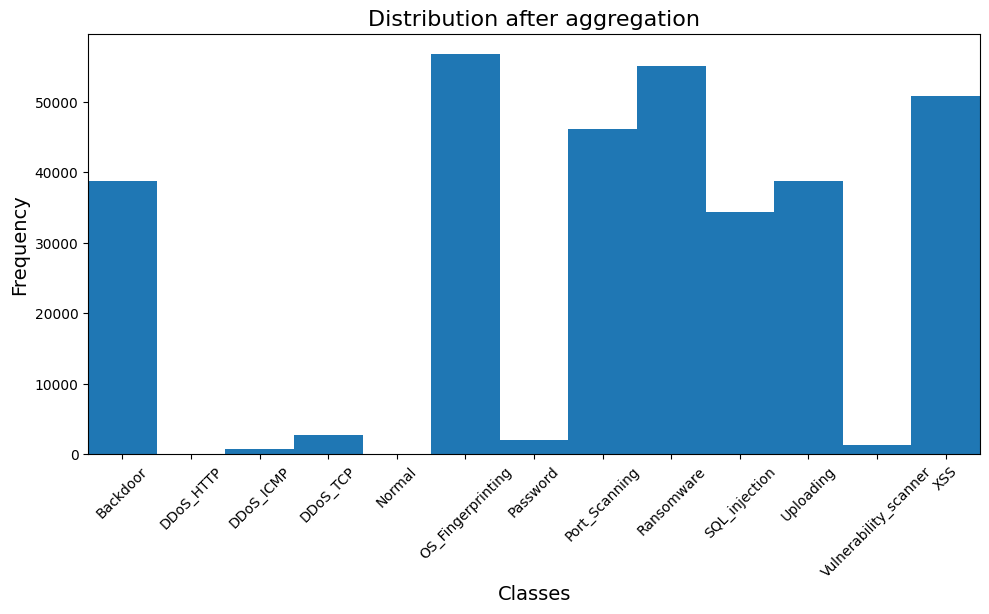

Fold 1
Epoch 1/50
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6693 - loss: 1.3326 - val_accuracy: 0.7768 - val_loss: 0.7555
Epoch 2/50
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7535 - loss: 0.8332 - val_accuracy: 0.8050 - val_loss: 0.6875
Epoch 3/50
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7741 - loss: 0.7704 - val_accuracy: 0.8107 - val_loss: 0.6394
Epoch 4/50
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7871 - loss: 0.7263 - val_accuracy: 0.8140 - val_loss: 0.6124
Epoch 5/50
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.7936 - loss: 0.7019 - val_accuracy: 0.8316 - val_loss: 0.5927
Epoch 6/50
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.8042 - loss: 0.6703 - val_accuracy: 0.8247 - val_loss: 0.5917
Epoch 7/50
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.8055 - loss: 0.6587 - val_accuracy: 0.8365 - val_loss: 0.5762
Epoch 8/50
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.80

c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7459
           1       0.00      0.00      0.00     44658
           2       1.00      0.90      0.95     43715
           3       1.00      0.58      0.74     42422
           5       0.05      0.99      0.09       300
           6       0.90      0.01      0.03     44242
           7       0.26      0.88      0.40      6769
           8       0.20      0.88      0.33      3278
           9       0.16      0.50      0.24     15361
          10       0.29      0.44      0.35     11290
          11       1.00      0.75      0.86     43761
          12       0.06      0.69      0.11      4775

    accuracy                           0.48    268030
   macro avg       0.49      0.63      0.42    268030
weighted avg       0.69      0.48      0.49    268030



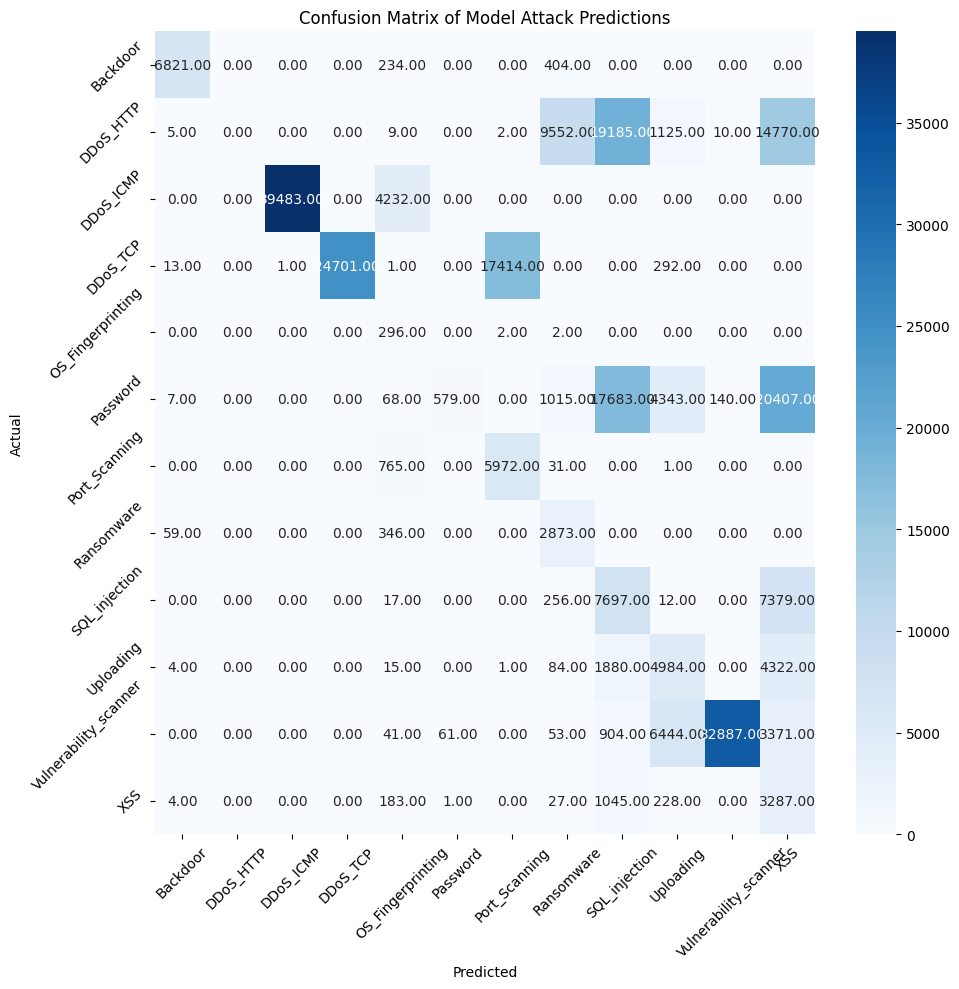

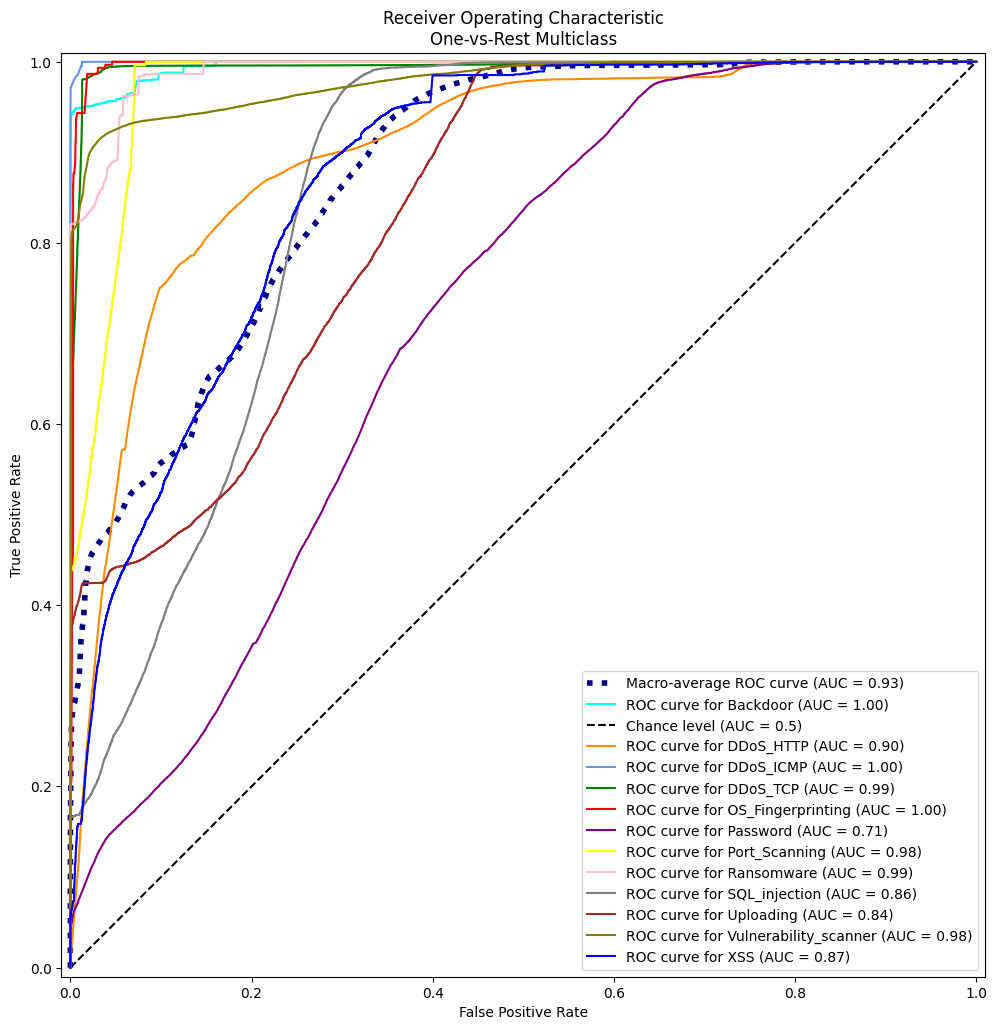

Processing interval: 5s
Number of rows after aggregation:  333488


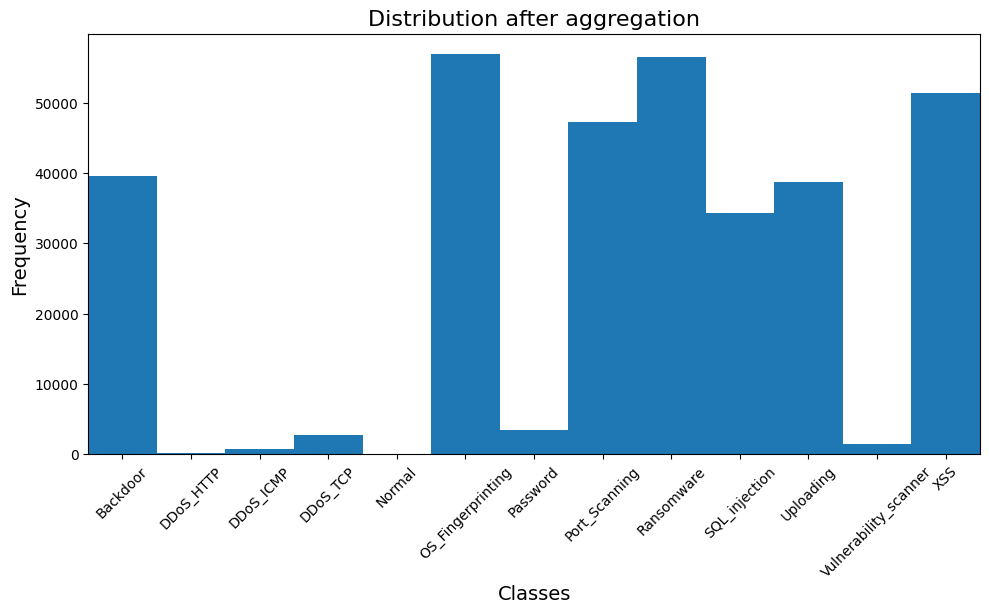

Fold 1
Epoch 1/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6657 - loss: 1.3558 - val_accuracy: 0.7699 - val_loss: 0.7924
Epoch 2/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.7474 - loss: 0.8589 - val_accuracy: 0.7940 - val_loss: 0.7143
Epoch 3/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - accuracy: 0.7642 - loss: 0.7985 - val_accuracy: 0.8043 - val_loss: 0.6565
Epoch 4/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.7818 - loss: 0.7472 - val_accuracy: 0.8198 - val_loss: 0.6261
Epoch 5/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.7890 - loss: 0.7197 - val_accuracy: 0.8329 - val_loss: 0.5983
Epoch 6/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7941 - loss: 0.6973 - val_accuracy: 0.8363 - val_loss: 0.5757
Epoch 7/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.7958 - loss: 0.6829 - val_accuracy: 0.8286 - val_loss: 0.5857
Epoch 8/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.

c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

              precision    recall  f1-score   support

           0       0.98      0.91      0.95      7459
           1       0.00      0.00      0.00     44658
           2       1.00      0.87      0.93     43715
           3       1.00      0.58      0.74     42422
           5       0.04      0.95      0.07       300
           6       0.83      0.01      0.03     44242
           7       0.26      0.92      0.41      6769
           8       0.19      0.89      0.32      3278
           9       0.19      0.53      0.28     15361
          10       0.16      0.45      0.23     11290
          11       0.94      0.50      0.65     43761
          12       0.06      0.65      0.11      4775

    accuracy                           0.44    268030
   macro avg       0.47      0.61      0.39    268030
weighted avg       0.67      0.44      0.45    268030



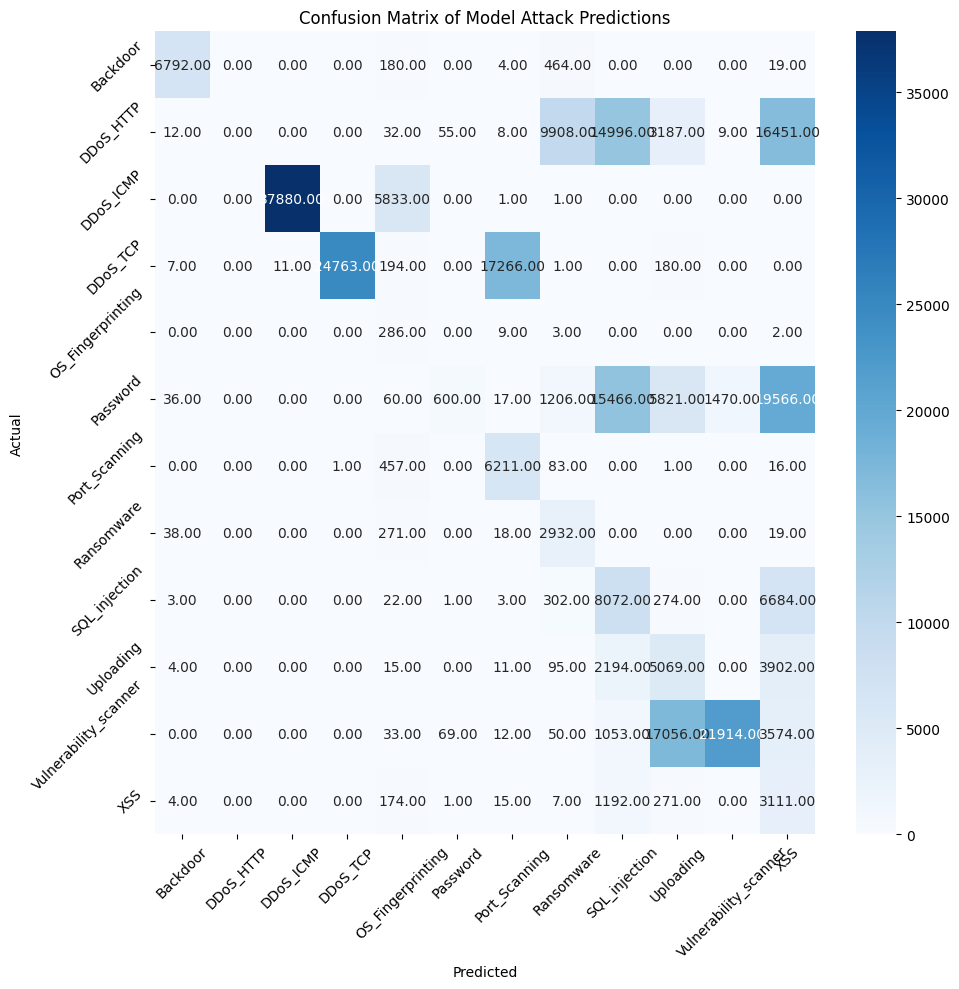

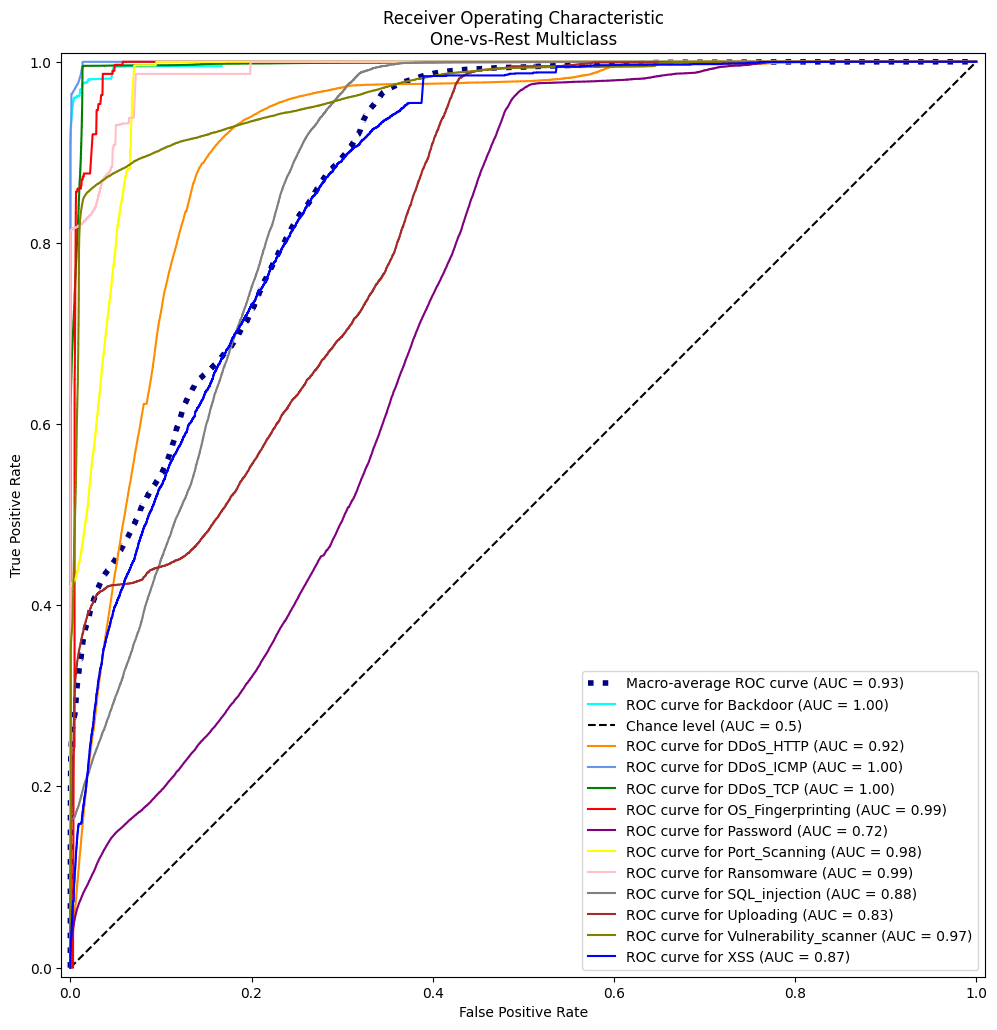

Processing interval: 3s
Number of rows after aggregation:  341220


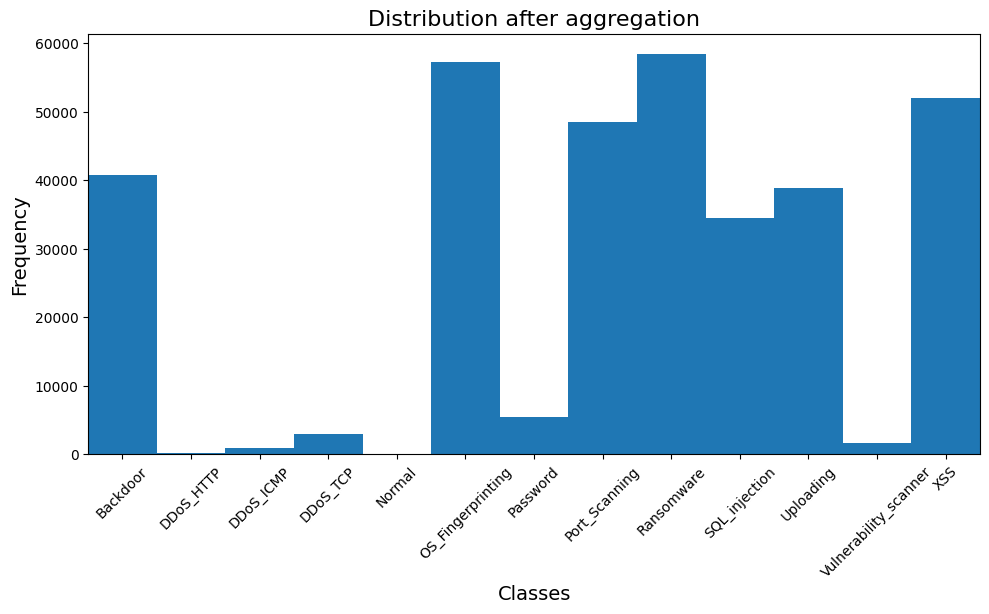

Fold 1
Epoch 1/50
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.6657 - loss: 1.3510 - val_accuracy: 0.7726 - val_loss: 0.7935
Epoch 2/50
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7430 - loss: 0.8812 - val_accuracy: 0.8016 - val_loss: 0.7153
Epoch 3/50
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.7673 - loss: 0.8073 - val_accuracy: 0.8082 - val_loss: 0.6640
Epoch 4/50
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.7828 - loss: 0.7612 - val_accuracy: 0.8294 - val_loss: 0.6326
Epoch 5/50
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - accuracy: 0.7907 - loss: 0.7285 - val_accuracy: 0.8316 - val_loss: 0.6056
Epoch 6/50
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.7950 - loss: 0.7085 - val_accuracy: 0.8401 - val_loss: 0.5822
Epoch 7/50
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.7988 - loss: 0.6951 - val_accuracy: 0.8351 - val_loss: 0.5883
Epoch 8/50
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.

c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      7459
           1       0.00      0.00      0.00     44658
           2       1.00      0.90      0.95     43715
           3       1.00      0.58      0.74     42422
           5       0.05      0.92      0.10       300
           6       0.94      0.08      0.15     44242
           7       0.27      0.96      0.42      6769
           8       0.15      0.85      0.25      3278
           9       0.18      0.44      0.26     15361
          10       0.22      0.44      0.29     11290
          11       1.00      0.70      0.82     43761
          12       0.07      0.76      0.12      4775

    accuracy                           0.49    268030
   macro avg       0.49      0.63      0.42    268030
weighted avg       0.70      0.49      0.50    268030



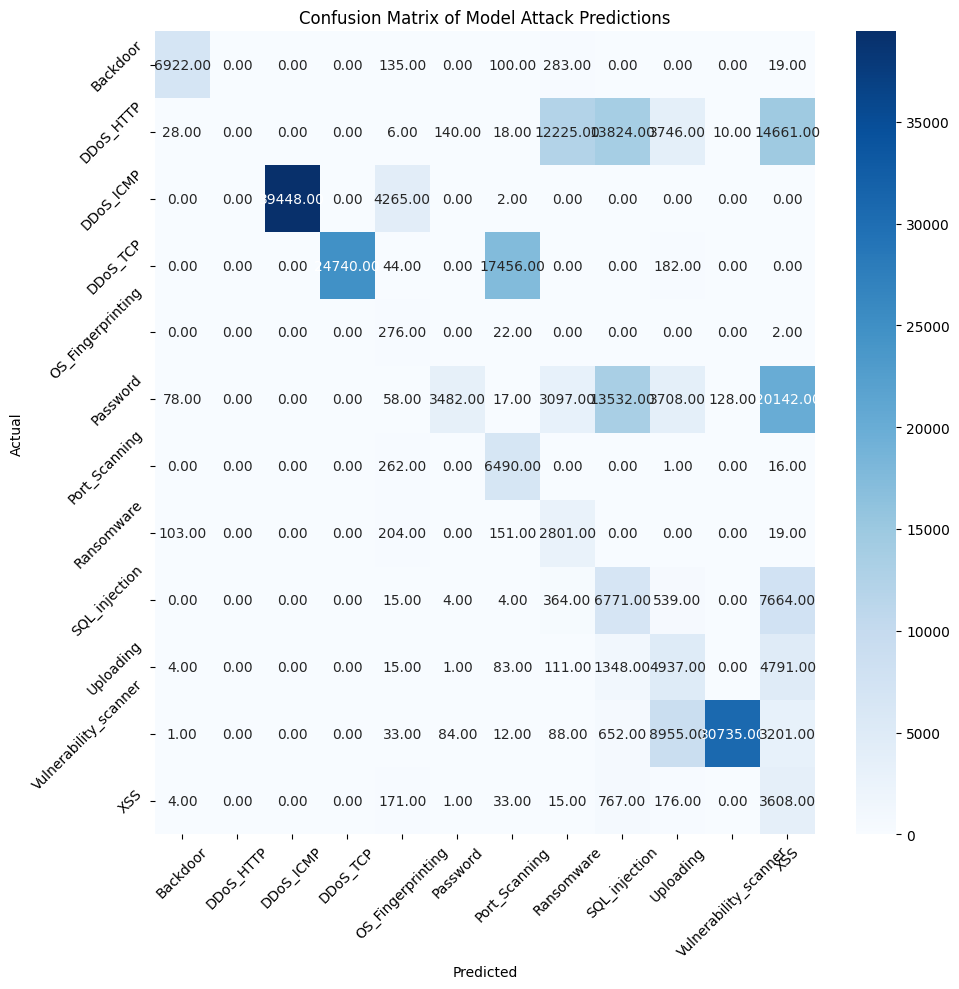

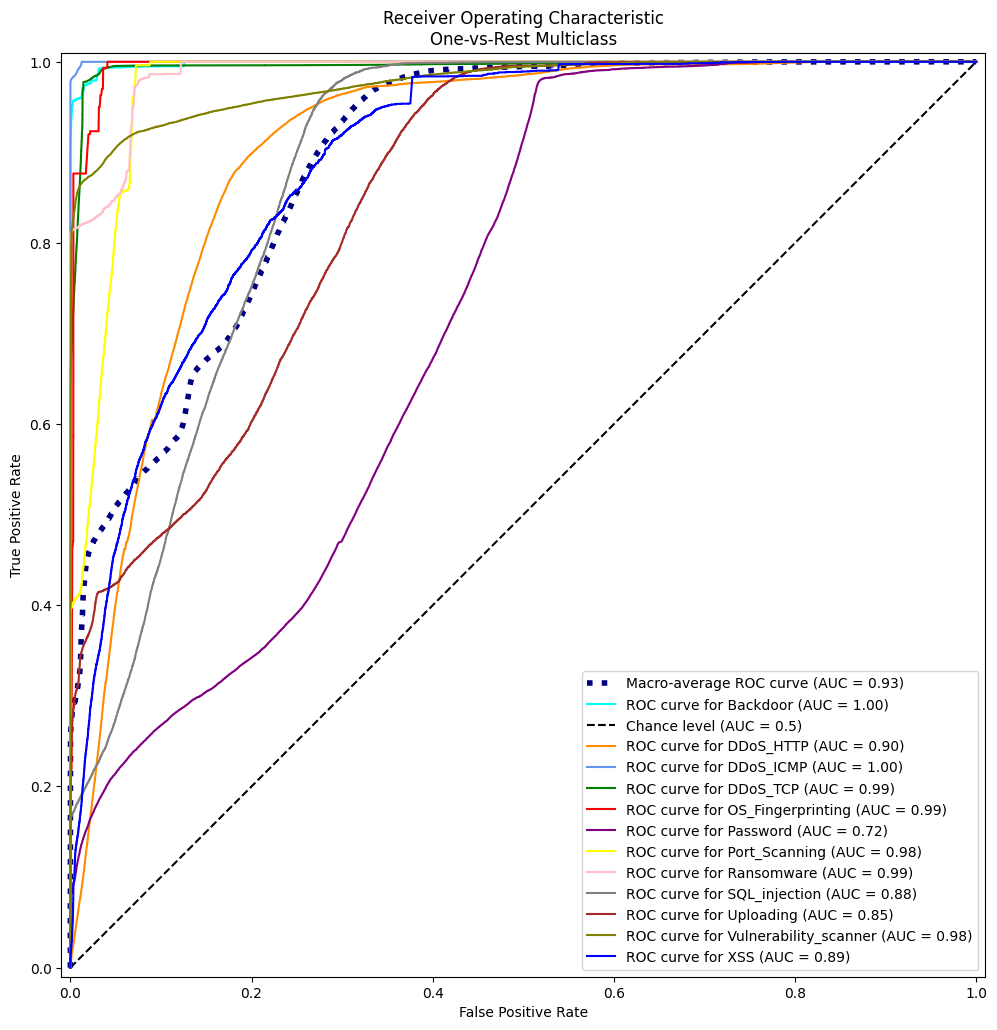

Processing interval: 2s
Number of rows after aggregation:  350606


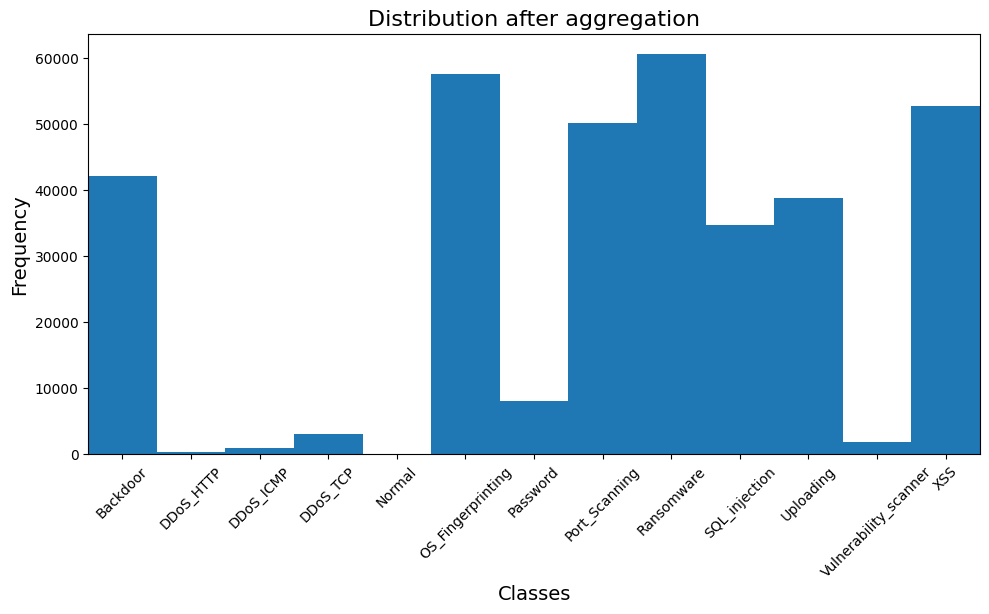

Fold 1
Epoch 1/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.6557 - loss: 1.3879 - val_accuracy: 0.7649 - val_loss: 0.8304
Epoch 2/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7357 - loss: 0.9004 - val_accuracy: 0.7857 - val_loss: 0.7642
Epoch 3/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7534 - loss: 0.8374 - val_accuracy: 0.7995 - val_loss: 0.6868
Epoch 4/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7683 - loss: 0.7920 - val_accuracy: 0.8056 - val_loss: 0.6577
Epoch 5/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7779 - loss: 0.7613 - val_accuracy: 0.8238 - val_loss: 0.6328
Epoch 6/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.7821 - loss: 0.7434 - val_accuracy: 0.8154 - val_loss: 0.6293
Epoch 7/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7878 - loss: 0.7227 - val_accuracy: 0.8243 - val_loss: 0.5975
Epoch 8/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7919 - 

c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7459
           1       0.00      0.00      0.00     44658
           2       1.00      0.96      0.98     43715
           3       1.00      0.58      0.74     42422
           5       0.09      0.99      0.16       300
           6       0.85      0.11      0.19     44242
           7       0.26      0.91      0.40      6769
           8       0.17      0.87      0.29      3278
           9       0.18      0.78      0.30     15361
          10       0.30      0.45      0.36     11290
          11       0.99      0.78      0.87     43761
          12       0.09      0.52      0.15      4775

    accuracy                           0.53    268030
   macro avg       0.49      0.66      0.45    268030
weighted avg       0.68      0.53      0.53    268030



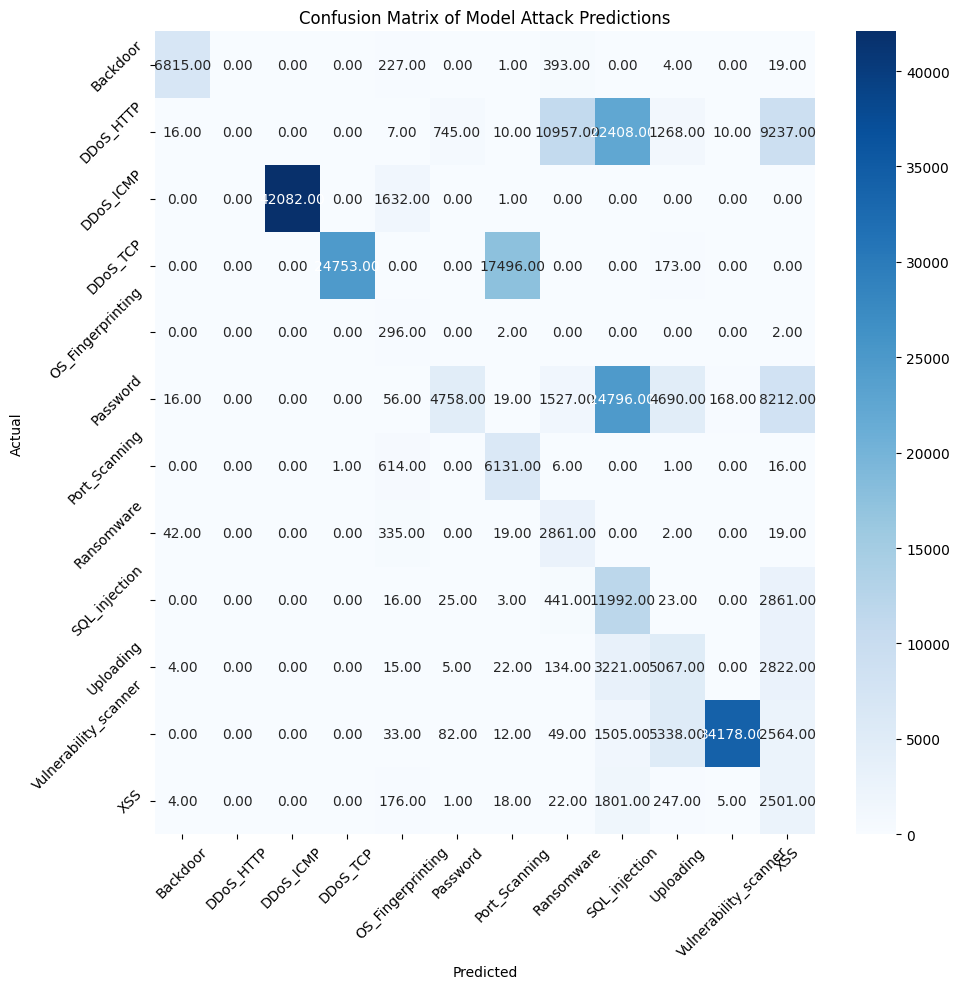

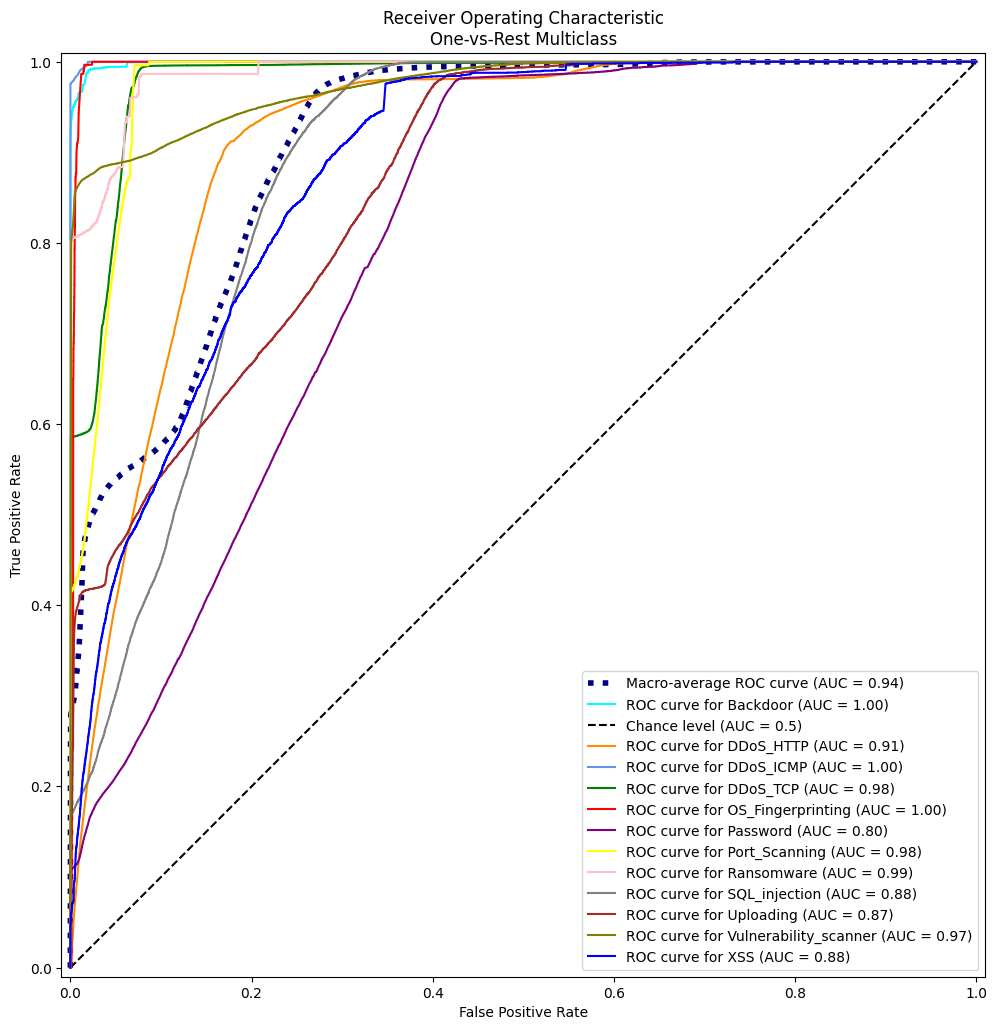

Processing interval: 1s
Number of rows after aggregation:  376686


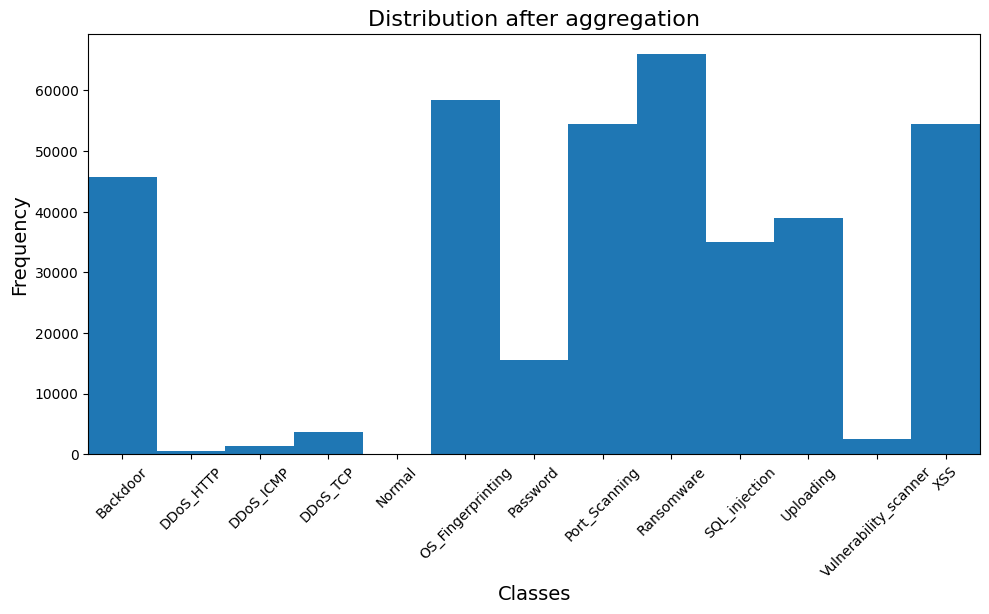

Fold 1
Epoch 1/50
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.6445 - loss: 1.3998 - val_accuracy: 0.7464 - val_loss: 0.8721
Epoch 2/50
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7277 - loss: 0.9302 - val_accuracy: 0.7707 - val_loss: 0.7785
Epoch 3/50
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.7488 - loss: 0.8568 - val_accuracy: 0.8073 - val_loss: 0.7055
Epoch 4/50
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.7652 - loss: 0.8142 - val_accuracy: 0.8130 - val_loss: 0.6797
Epoch 5/50
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.7730 - loss: 0.7858 - val_accuracy: 0.8091 - val_loss: 0.6688
Epoch 6/50
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7770 - loss: 0.7699 - val_accuracy: 0.8237 - val_loss: 0.6393
Epoch 7/50
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.7803 - loss: 0.7516 - val_accuracy: 0.8243 - val_loss: 0.6357
Epoch 8/50
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0

c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7459
           1       0.00      0.00      0.00     44658
           2       1.00      0.96      0.98     43715
           3       1.00      0.59      0.74     42422
           5       0.09      0.92      0.17       300
           6       0.56      0.18      0.27     44242
           7       0.27      0.96      0.42      6769
           8       0.26      0.88      0.40      3278
           9       0.17      0.57      0.26     15361
          10       0.36      0.44      0.39     11290
          11       1.00      0.80      0.89     43761
          12       0.07      0.63      0.13      4775

    accuracy                           0.54    268030
   macro avg       0.48      0.65      0.47    268030
weighted avg       0.64      0.54      0.54    268030



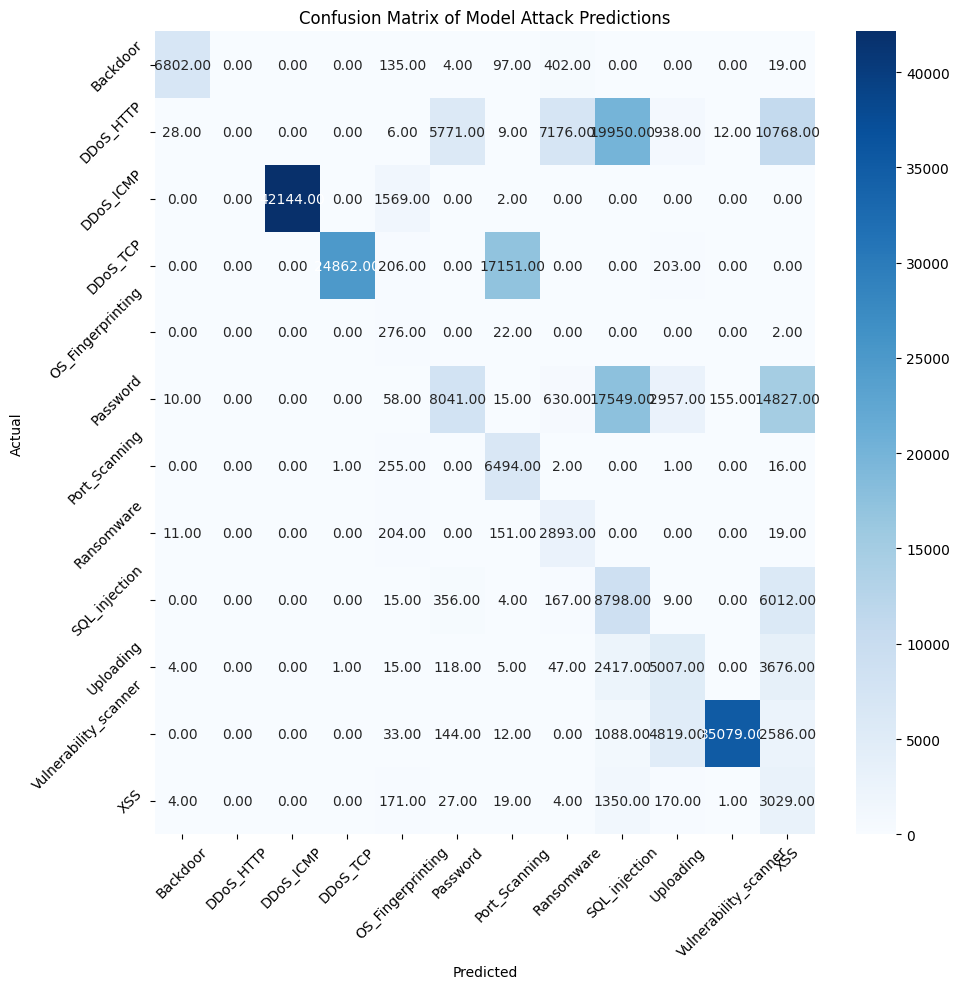

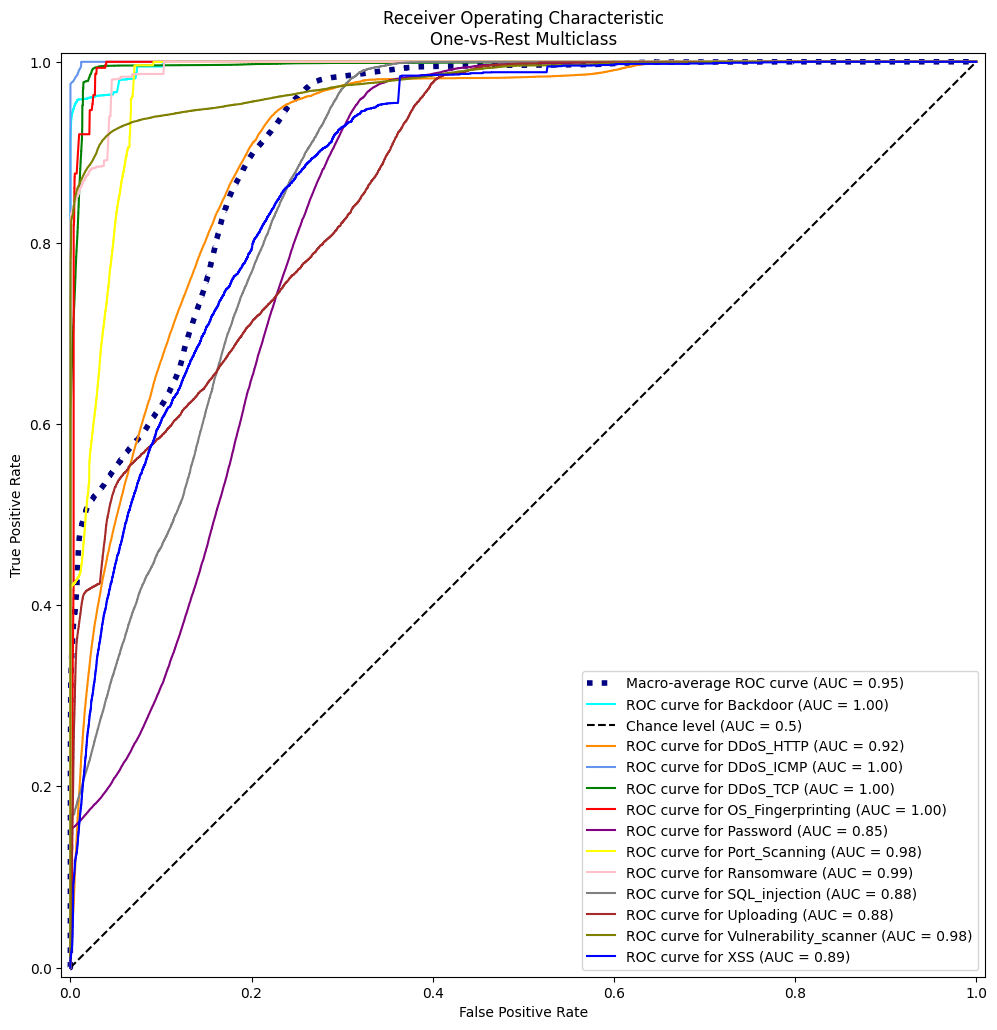

In [20]:
# Training with different time buckets
intervals = [10, 5, 3, 2, 1]  # in seconds
checkpoint_dir = './checkpoints/'

for interval in intervals:
    print(f"Processing interval: {interval}s")
    os.makedirs(f"{checkpoint_dir}/{interval}s/", exist_ok=True)
    
    # Load and discretize data
    X_train, y_train = discretize_by_time_buckets(combined_df.copy(), interval)
    X_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Check distribution after aggregation
    hist(y_train)
    plt.title('Distribution after aggregation', fontsize=16)
    plt.show()
    
    # 5-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    input_shape = (X_cnn.shape[1], 1)
    all_scores = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X_cnn)):
        print(f"Fold {fold+1}")
        
        X_train_fold, X_val_fold = X_cnn[train_index], X_cnn[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Create a new model for each fold
        model = create_model(input_shape)
        
        # Model checkpointing for each fold
        checkpoint_filepath = f"{checkpoint_dir}/{interval}s/fold_{fold+1}_cnn_checkpoint.model.keras"
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True
        )
        
        # Early stopping
        early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
        
        # Train the model
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=128,
                  validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stopping])
        
        # Evaluate the model on the validation set
        score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        all_scores.append(score)

    # Print cross-validation results
    mean_score = np.mean(all_scores, axis=0)
    std_score = np.std(all_scores, axis=0)
    print(f'Interval {interval}s - Mean Validation Loss: {mean_score[0]:.4f}, Mean Validation Accuracy: {mean_score[1]:.4f}')
    print(f'Interval {interval}s - Std Dev Loss: {std_score[0]:.4f}, Std Dev Accuracy: {std_score[1]:.4f}')

    # classification report
    y_pred = model.predict(X_test_cnn)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(classification_report(y_test, y_pred_classes))

    conf_matrix(y_pred_classes)

    auc_roc_curve(y_pred)
